In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
import random
import cv2
import os
import tensorflow as tf
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras import backend as K
from skimage.metrics import structural_similarity as compare_ssim


seed = 21
random.seed = seed
np.random.seed = seed

In [6]:
sharp_folders='/content/drive/MyDrive/Assigment/sharp'
blur_folders='/content/drive/MyDrive/Assigment/defocused_blurred'


In [7]:

sharp_images=[]
blurred_images=[]

for file in tqdm(sorted(os.listdir(sharp_folders))):
    if any(extension in file for extension in ['.jpg','jpeg','png']):
        image=tf.keras.preprocessing.image.load_img(sharp_folders+'/'+file,target_size=(128,128))
        image=tf.keras.preprocessing.image.img_to_array(image).astype('float32')/255
        sharp_images.append(image)


sharp_images=np.array(sharp_images)

for file in tqdm(sorted(os.listdir(blur_folders))):
    if any(extension in file for extension in ['.jpg','jpeg','png']):
        image=tf.keras.preprocessing.image.load_img(blur_folders+'/'+file,target_size=(128,128))
        image=tf.keras.preprocessing.image.img_to_array(image).astype('float32')/255
        blurred_images.append(image)

blurred_images=np.array(blurred_images)




100%|██████████| 350/350 [02:56<00:00,  1.99it/s]


113


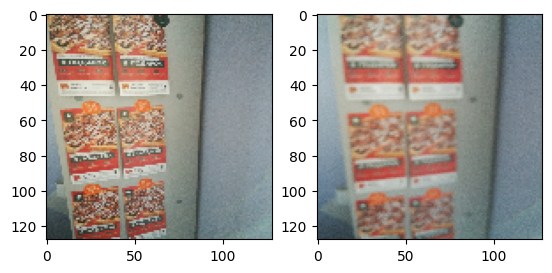

In [ ]:
r = random.randint(0, len(sharp_images)-1)
print(r)
fig = plt.figure()
fig.subplots_adjust(hspace=0.1, wspace=0.2)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(sharp_images[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(blurred_images[r])

# Model Building

In [8]:
# Network Parameters
input_shape = (128, 128, 3)
batch_size = 32
kernel_size = 3
latent_dim = 256   #  The dimensionality of the latent space representation.

# Encoder/Decoder number of CNN layers and filters per layer
layer_filters = [64, 128, 256]

In [9]:
inputs = Input(shape = input_shape, name = 'encoder_input')
x = inputs

for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

shape = K.int_shape(x)
x = Flatten()(x)     #  Retrieves the shape of the tensor x as a tuple.
latent = Dense(latent_dim, name='latent_vector')(x)

encoder = Model(inputs, latent, name='encoder')
encoder.summary()



Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 256)       295168    
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 latent_vector (Dense)       (None, 256)               16777472  
                                                                 
Total params: 17148288 (65.42 MB)
Trainable params: 1714828

In [10]:
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)   # increase the dimensionality of the latent vector

x = Reshape((shape[1], shape[2], shape[3]))(x)

for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

outputs = Conv2DTranspose(filters=3,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)




decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()



Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 256)]             0         
                                                                 
 dense (Dense)               (None, 65536)             16842752  
                                                                 
 reshape (Reshape)           (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 32, 32, 256)       590080    
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 64, 64, 128)       295040    
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 128, 128, 64)      7379

In [11]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 128, 128, 3)]     0         
                                                                 
 encoder (Functional)        (None, 256)               17148288  
                                                                 
 decoder (Functional)        (None, 128, 128, 3)       17803395  
                                                                 
Total params: 34951683 (133.33 MB)
Trainable params: 34951683 (133.33 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
autoencoder.compile(loss='mse', optimizer='adam',metrics=["acc"])

In [14]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)


callbacks=[lr_reducer]


In [15]:
history = autoencoder.fit(blurred_images,
                      sharp_images,
                      validation_data=(blurred_images, sharp_images),
                      epochs=100,
                      batch_size=batch_size,
                      callbacks=callbacks)

Epoch 1/100
9/9 [==============================] - 11s 385ms/step - loss: 0.0697 - acc: 0.6318 - val_loss: 0.0681 - val_acc: 0.6688 - lr: 0.0010
Epoch 2/100
9/9 [==============================] - 1s 130ms/step - loss: 0.0677 - acc: 0.6688 - val_loss: 0.0673 - val_acc: 0.6688 - lr: 0.0010
Epoch 3/100
9/9 [==============================] - 1s 129ms/step - loss: 0.0662 - acc: 0.6681 - val_loss: 0.0641 - val_acc: 0.6508 - lr: 0.0010
Epoch 4/100
9/9 [==============================] - 1s 128ms/step - loss: 0.0615 - acc: 0.6664 - val_loss: 0.0555 - val_acc: 0.6687 - lr: 0.0010
Epoch 5/100
9/9 [==============================] - 1s 128ms/step - loss: 0.0530 - acc: 0.6608 - val_loss: 0.0491 - val_acc: 0.6554 - lr: 0.0010
Epoch 6/100
9/9 [==============================] - 1s 129ms/step - loss: 0.0493 - acc: 0.6655 - val_loss: 0.0481 - val_acc: 0.6686 - lr: 0.0010
Epoch 7/100
9/9 [==============================] - 1s 128ms/step - loss: 0.0470 - acc: 0.6683 - val_loss: 0.0438 - val_acc: 0.6650 - lr


       Input                        Ground Truth                  Predicted Value
1/1 [==============================] - 0s 19ms/step


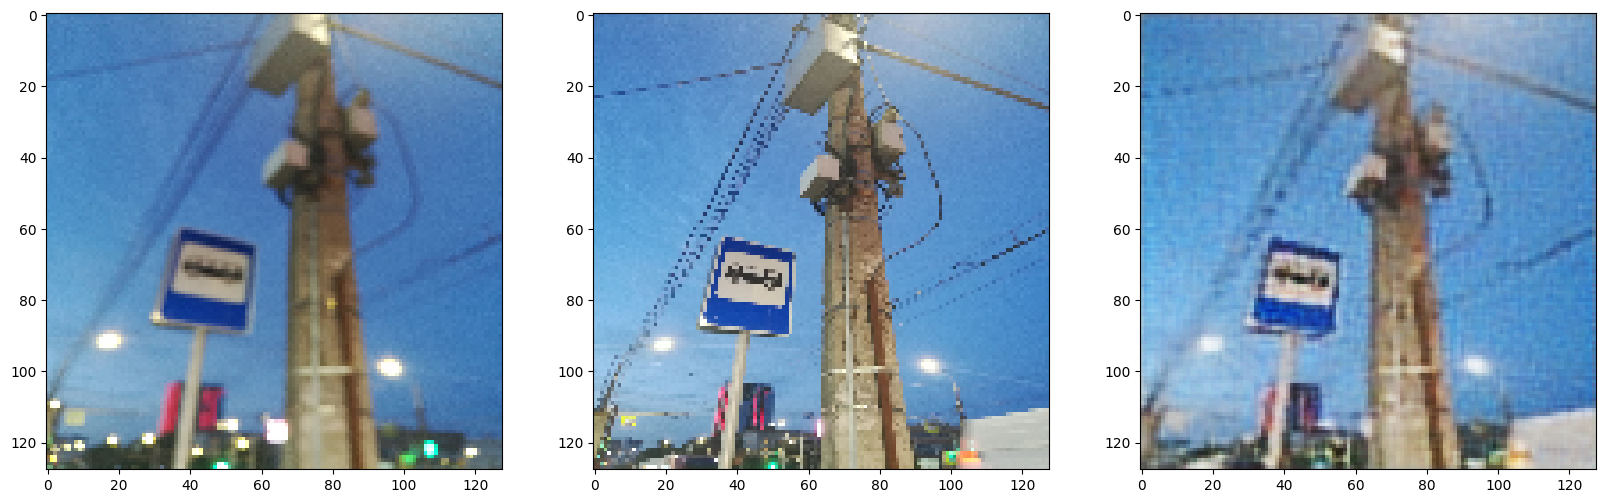

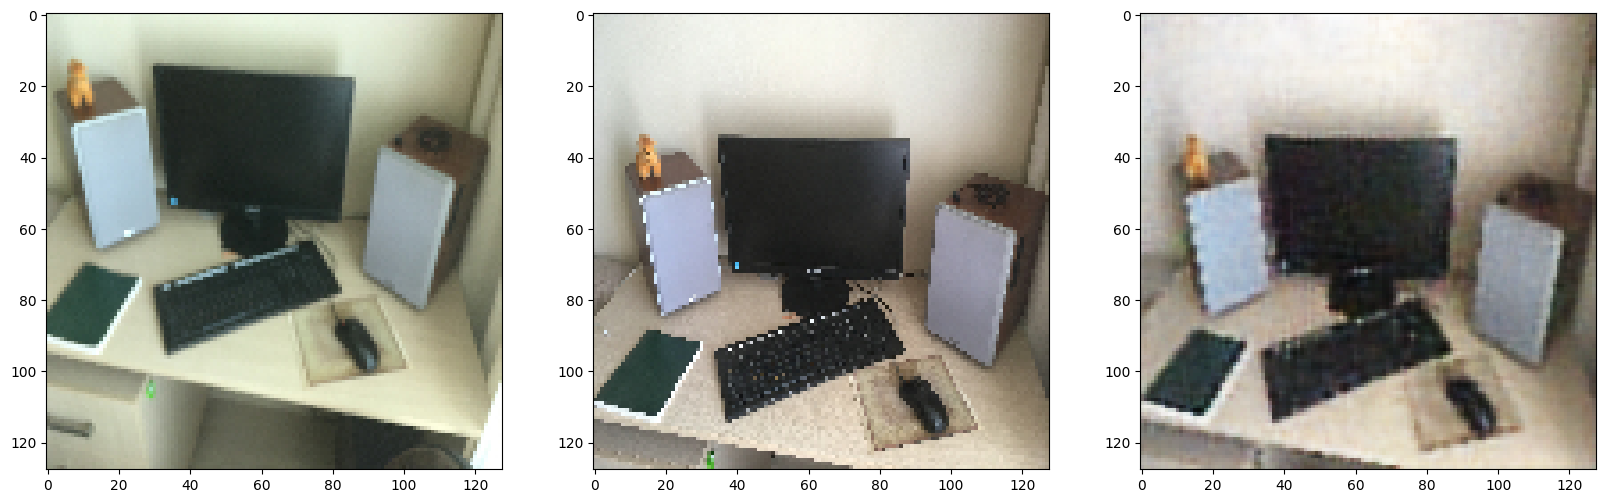

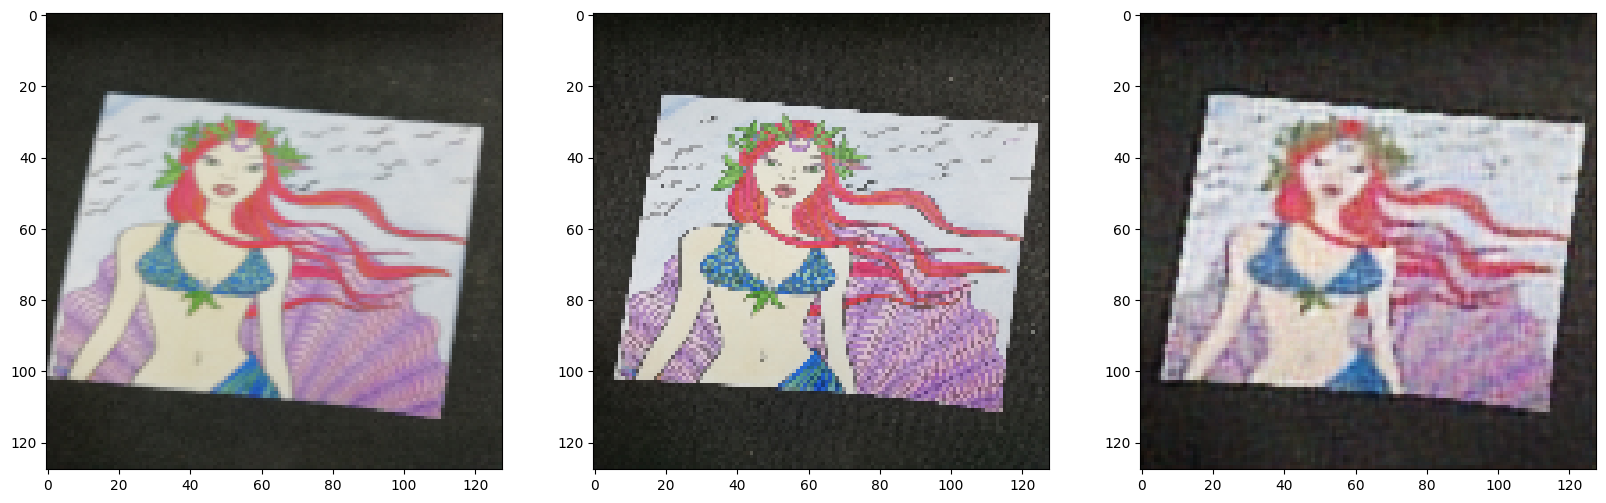

In [16]:
print("\n       Input                        Ground Truth                  Predicted Value")
for i in range(3):

    r = random.randint(0, len(sharp_images)-1)

    x, y = blurred_images[r],sharp_images[r]
    x_inp=x.reshape(1,128,128,3)
    result = autoencoder.predict(x_inp)
    result = result.reshape(128,128,3)

    fig = plt.figure(figsize=(20,18))
    fig.subplots_adjust(hspace=0.1, wspace=0.2)

    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(x)

    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(y)

    ax = fig.add_subplot(1, 3, 3)
    plt.imshow(result)

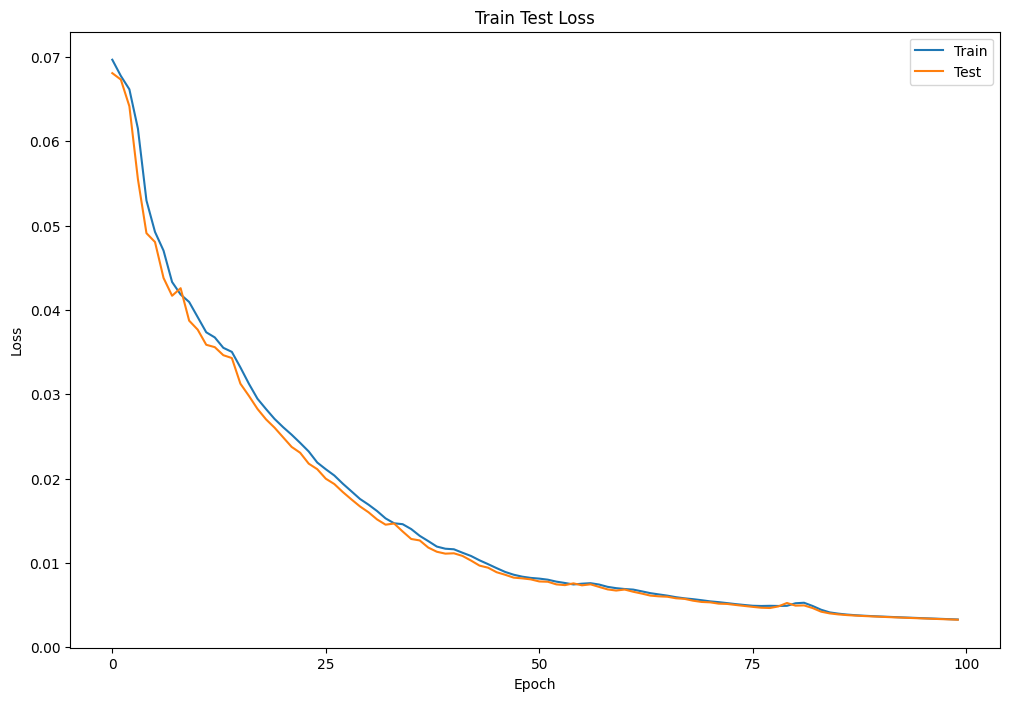

In [18]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Test'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.arange(0, 101, 25))
plt.title('Train Test Loss')
plt.show()

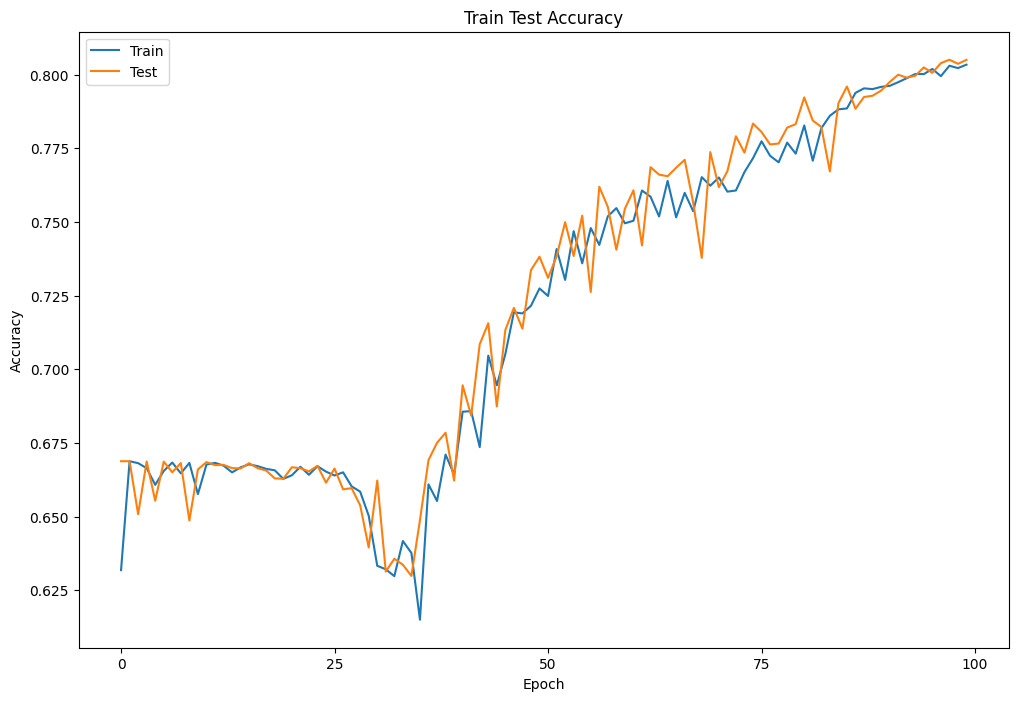

In [19]:
plt.figure(figsize=(12,8))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['Train', 'Test'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(np.arange(0, 101, 25))
plt.title('Train Test Accuracy')
plt.show()

In [20]:
def predict_result(test_img):
    predict = test_img.reshape(1,128,128,3)
    result =  autoencoder.predict(predict)
    result = result.reshape(128,128,3)

    fig = plt.figure(figsize = (8,8))
    fig.subplots_adjust(hspace=0.1, wspace=0.2)
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(test_img)
    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(result)

1/1 [==============================] - 0s 21ms/step


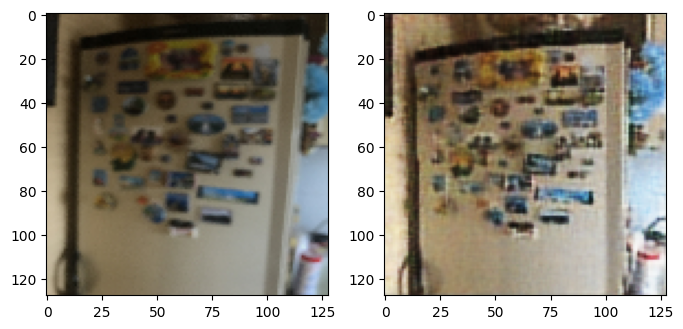

In [23]:
path_to_test="/content/drive/MyDrive/Assigment/defocused_blurred/195_IPHONE-7_F.jpeg"
test_img = tf.keras.preprocessing.image.load_img(path_to_test, target_size=(128,128))
test_img = tf.keras.preprocessing.image.img_to_array(test_img).astype('float32') / 255
predict_result(test_img)

In [24]:
from tensorflow.keras.models import load_model
autoencoder.save('/content/drive/MyDrive/Assigment/autoencoder_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [25]:
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity, mean_squared_error

# Evaluate performance metrics
psnr_scores = []
mse_scores = []

for i in range(len(blurred_images)):
    x_inp = blurred_images[i].reshape(1, 128, 128, 3)
    predicted = autoencoder.predict(x_inp).reshape(128, 128, 3)
    original = sharp_images[i]

    psnr = peak_signal_noise_ratio(original, predicted)
    mse = mean_squared_error(original, predicted)

    psnr_scores.append(psnr)
    mse_scores.append(mse)
avg_psnr = np.mean(psnr_scores)
avg_mse = np.mean(mse_scores)

# Print average scores
print("Average PSNR:", avg_psnr)
print("Average MSE:", avg_mse)

1/1 [==============================] - 0s 18ms/step
Average PSNR: 25.650118283776322
Average MSE: 0.0032674982669506545
